# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns
from scipy.stats import skew, kurtosis

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
article_counts = df.groupby('email')['article_id'].count()

In [4]:
extended_descriptive_stats = article_counts.describe()
extended_descriptive_stats['skew'] = skew(article_counts)
extended_descriptive_stats['kurtosis'] = kurtosis(article_counts)

/tmp/ipykernel_5640/1211572237.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(article_counts, shade=True)


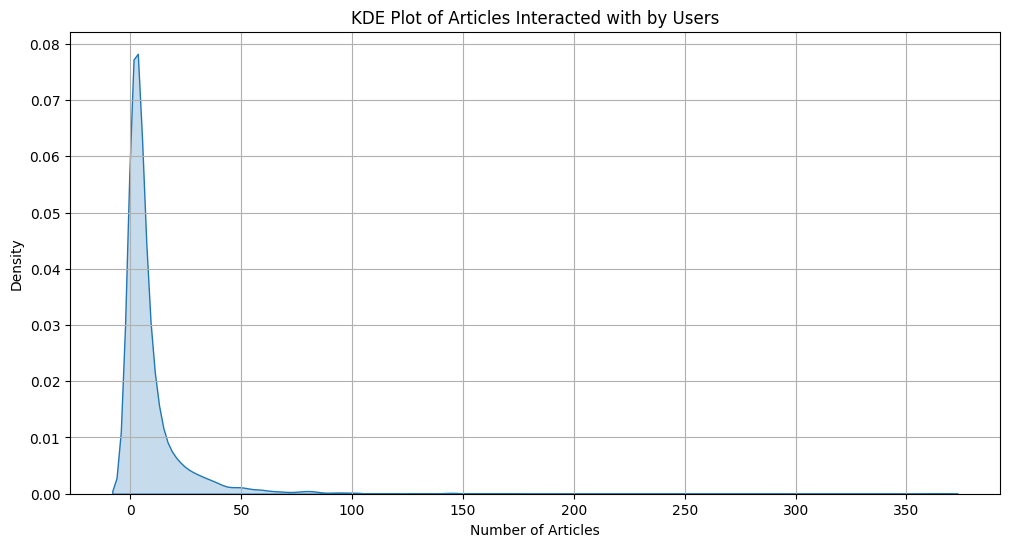

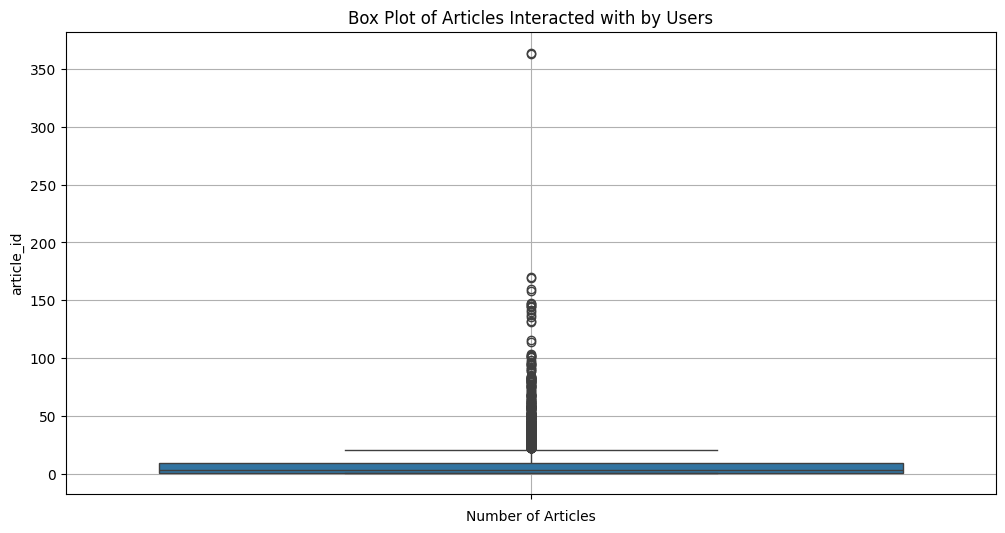

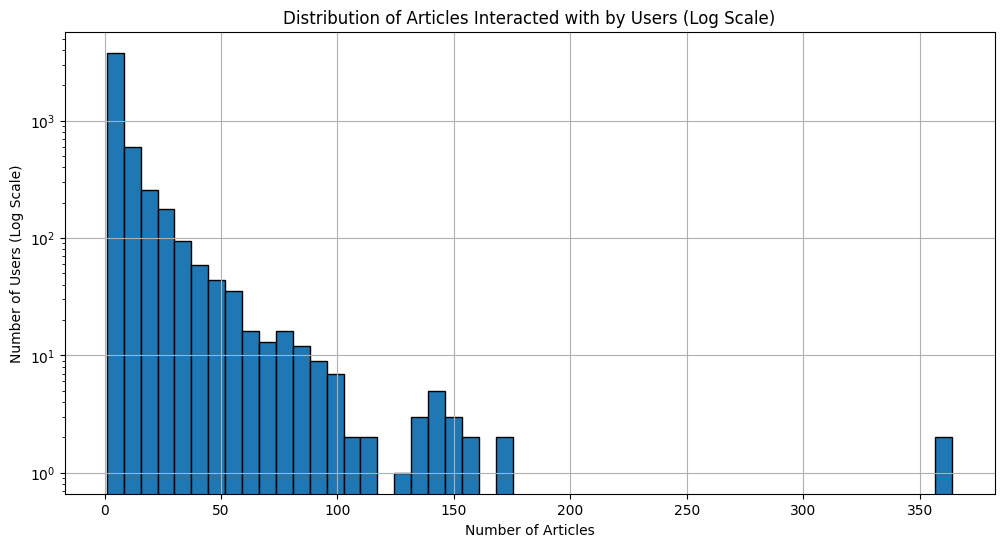

In [5]:
# KDE Plot
plt.figure(figsize=(12, 6))
sns.kdeplot(article_counts, shade=True)
plt.xlabel('Number of Articles')
plt.ylabel('Density')
plt.title('KDE Plot of Articles Interacted with by Users')
plt.grid(True)
plt.show()

# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(article_counts)
plt.xlabel('Number of Articles')
plt.title('Box Plot of Articles Interacted with by Users')
plt.grid(True)
plt.show()

# Histogram with Log Scale
plt.figure(figsize=(12, 6))
plt.hist(article_counts, bins=50, edgecolor='black', log=True)
plt.xlabel('Number of Articles')
plt.ylabel('Number of Users (Log Scale)')
plt.title('Distribution of Articles Interacted with by Users (Log Scale)')
plt.grid(True)
plt.show()

In [6]:
# Fill in the median and maximum number of user_article interactios below
mean_count = article_counts.mean()
median_count = article_counts.median()
mode_count = article_counts.mode()[0]

median_val = median_count
max_views_by_user = article_counts.max()

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
duplicated_art = df_content[df_content['article_id'].duplicated(keep=False)]

In [8]:
duplicated_art.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398


In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'], keep='first')

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
unique_articles = df.groupby('article_id').count().shape[0]
total_articles = df_content['article_id'].count()
unique_users = df.groupby('email').count().shape[0]
user_article_interactions = df['article_id'].shape[0]

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [11]:
article_id = df['article_id'].mode()[0]
article = df.loc[[article_id]]

most_viewed_article_id = str(article_id)
max_views = df[df['article_id'] == article_id].shape[0]

In [12]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [13]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [14]:
def get_ranked_articles(df=df):
    '''
    INPUT:
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    ranked_df - (pandas dataframe) df as ranked articles
    
    '''
    ranked_df = df.groupby('article_id').count()
    ranked_df.reset_index(inplace=True)
    del ranked_df['user_id']
    ranked_df = ranked_df.rename(columns={'title': 'rank'})
    ranked_df = ranked_df.sort_values(by=['rank'], ascending=False)
    return ranked_df
    

def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    rank_df = get_ranked_articles(df)
    top_articles = rank_df.iloc[:n].get("article_id")
    top_articles = list(top_articles)
    title = df[df['article_id'].isin(top_articles)].get('title')
    title = list(title)
    
    return title

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    rank_df = get_ranked_articles(df)
    top_articles = rank_df.iloc[:n].get("article_id")
    top_articles = list(top_articles)
 
    return top_articles

In [15]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [16]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item = user_item.notnull().astype(int)
    
    return user_item

user_item = create_user_item_matrix(df)

In [17]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [18]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    target_user = user_item.loc[user_id]

    # Compute dot product similarity of the target row with all rows
    similarities = user_item.dot(target_user)

    # Convert to a DataFrame for better readability
    similarity_df = pd.DataFrame(similarities, columns=['similarity'])

    # sort by similarity
    similarity_df = similarity_df.sort_values(by=['similarity'], ascending=False)

    # create list of just the ids
    most_similar_users = list(similarity_df.index.values)
    
    most_similar_users.remove(user_id)
   
    return most_similar_users # return a list of the users in order from most to least similar
        

In [19]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [20]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
    '''
    # Get unique article_id and title pairs
    articles = df[['article_id', 'title']].drop_duplicates()
    
    article_ids = [float(i) for i in article_ids]
    
    # Filter articles by article_ids using merge
    specific_articles = pd.DataFrame({'article_id': article_ids})
    merged_df = pd.merge(specific_articles, articles, on='article_id', how='inner')
    
    # Get article names associated with list of article ids
    article_names = merged_df['title'].tolist()
    
    return article_names


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    #Get the user
    target_user = user_item.loc[user_id]
    
    #Get the articles
    article_ids = list(target_user.index[target_user == 1])
    
    #Convert to string and sort it
    article_ids = [str(i) for i in article_ids]
    article_ids.sort()
    
    #Get the article names
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    '''
    
    #Get the articles that the user has seen before
    user_seen_articles = get_user_articles(user_id)
    recs = set()
    
    #Get the similar users
    similar_users = find_similar_users(user_id)
    for similar_user_id in similar_users:
        article_ids, _ = get_user_articles(similar_user_id)
        
        #Get the articles seen by the similar users
        for article_id in article_ids:
            if article_id not in user_seen_articles:
                recs.add(article_id)
                
                #Return the m recomendations
                if len(recs) == m:
                    return list(recs)
    
    return list(recs)

In [21]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['apache spark lab, part 1: basic concepts',
 'tensorflow quick tips',
 'categorize urban density',
 'country statistics: life expectancy at birth',
 'finding optimal locations of new store using decision optimization',
 'gosales transactions for naive bayes model',
 'access db2 warehouse on cloud and db2 with python',
 'classify tumors with machine learning',
 'predict loan applicant behavior with tensorflow neural networking',
 'putting a human face on machine learning']

In [22]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [23]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    target_user = user_item.loc[user_id]

    # Compute dot product similarity of the target row with all rows
    similarities = user_item.dot(target_user)

    # Convert to a DataFrame for better readability
    similarity_df = pd.DataFrame(similarities, columns=['similarity'])
    
    #Calculate the users interactions count
    users_interactions = user_item.apply(lambda x: (x == 1).sum(), axis=0)

    #Create the neighbors_df
    neighbors_df = pd.DataFrame(users_interactions, columns=['num_interactions'])

    #join the dataframes
    neighbors_df = neighbors_df.join(similarity_df, how='inner')

    # sort by similarity and num_interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df 


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    '''
    #Get the articles that the user has seen before
    user_seen_articles = get_user_articles(user_id)
    recs = list()
    
    ranked_articles = get_ranked_articles()
    
    #Get the similar users
    similar_users = get_top_sorted_users(user_id)
    for similar_user_id in similar_users.index.values:
        article_ids, _ = get_user_articles(similar_user_id)
        
        article_ids = [float(i) for i in article_ids]
        specific_articles = pd.DataFrame({'article_id': article_ids})
        specific_articles = pd.merge(specific_articles, ranked_articles, on='article_id', how='inner')

        #Get the articles seen by the similar users
        for article_id in specific_articles['article_id']:
            if article_id not in user_seen_articles:
                recs.append(article_id)
                
                #Return the m recomendations
                if len(recs) == m:
                    rec_names = get_article_names(recs)
                    return recs, rec_names
                

In [24]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1320.0, 232.0, 844.0, 1006.0, 1035.0, 109.0, 111.0, 112.0, 1154.0, 1160.0]

The top 10 recommendations for user 20 are the following article names:
['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery', 'use the cloudant-spark connector in python notebook', 'essentials of machine learning algorithms (with python and r codes)', 'machine learning for the enterprise.', 'tensorflow quick tips', 'tidy up your jupyter notebooks with scripts', 'building custom machine learning algorithms with apache systemml', 'airbnb data for analytics: vienna listings', 'analyze accident reports on amazon emr spark']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [25]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0]
user131_10th_sim = find_similar_users(131)[10]

In [26]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [27]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(i) for i in get_top_article_ids(10)]

In [28]:
assert set(new_user_recs) == set(["1429.0", "1330.0", "1431.0", "1427.0", "1364.0", "1314.0", "1293.0", "1170.0", "1162.0", "1304.0"]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [29]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [30]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [31]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True)

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

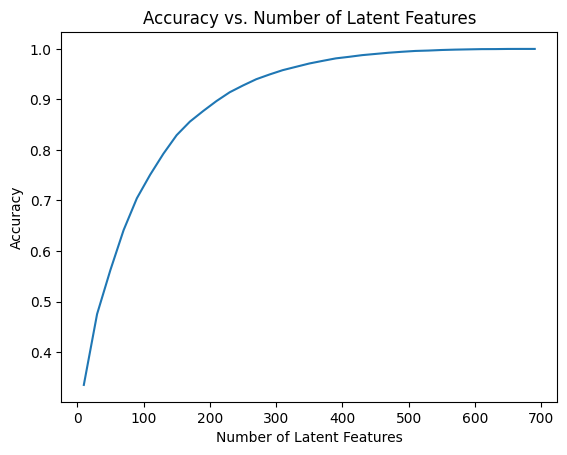

In [32]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [33]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    # Test user ids
    test_idx = user_item_test.index
    test_idx = list(set(test_idx))
    
    # Test article ids
    test_arts = user_item_test.columns
    test_arts = list(set(test_arts))
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [34]:
# How many users can we make predictions for in the test set?
len(np.intersect1d(df_train['user_id'].unique(),df_test['user_id'].unique()))

20

In [35]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
len(df_test['user_id'].unique()) - len(np.intersect1d(df_train['user_id'].unique(),df_test['user_id'].unique()))

662

In [36]:
# How many articles can we make predictions for in the test set?
len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique()))

574

In [37]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
len(df_test['article_id'].unique()) - len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique()))

0

In [38]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [39]:
# Fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

Use these cells to see how well you can use the training decomposition to predict on test data

In [40]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

# Users and articles in user_item_train matrix
train_idx = np.array(user_item_train.index)
train_arts = np.array(user_item_train.columns)

# Users and articles of test set in training set
test_idx_set = np.intersect1d(test_idx, train_idx)
test_arts_set = np.intersect1d(test_arts, train_arts)

# Users and articles positions of test subset in training matrix
train_indexes = np.where(np.in1d(train_idx, test_idx_set))[0]
train_articles = np.where(np.in1d(train_arts, test_arts_set))[0]

# Users positions of test subset in test matrix
test_indexes = np.where(np.in1d(test_idx, test_idx_set))[0]

In [41]:
# FIND SUBSET OF USER_ITEM MATRIX CONTAINING ONLY USER AND ARTICLES THAT ARE SHARED BY TRAIN AND TEST SET
u_item_test_set = user_item_test.iloc[test_indexes,:]
u_item_train_set = user_item_train.iloc[train_indexes, train_articles]

In [42]:
latent_feats = np.arange(10,570,10)
sum_errors = []

for k in latent_feats:
    
    # Restructure train matrices using k features
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # Restructure test matrices using k features
    s_test_k, u_test_k, vt_test_k = s_train_k, u_train_k[train_indexes,:], vt_train_k[:,train_articles]
    
    # Calculate dot product
    u_item_test_set_pred = np.around(np.dot(np.dot(u_test_k, s_test_k), vt_test_k))
    
    # Error (prediction - actual values)
    error = np.subtract(u_item_test_set, u_item_test_set_pred)
    
    # Total errors
    total_error = np.sum(np.sum(np.abs(error)))
    sum_errors.append(total_error)

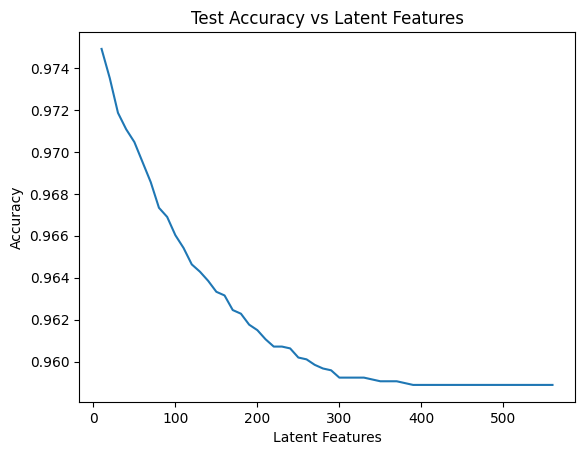

In [44]:
# Plot test accuracy and latent features
n_interactions_set = u_item_test_set.shape[0] * u_item_test_set.shape[1]
plt.plot(latent_feats, 1 - np.array(sum_errors) / n_interactions_set);
plt.xlabel('Latent Features');
plt.ylabel('Accuracy');
plt.title('Test Accuracy vs Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

Analyzing the accuracy associated with the training data, it tends to increase towards one hundred percent as the number of latent features increases. On the other hand, the accuracy associated with the test data tends to decrease as the latent features increase. This discrepancy could be due to the lack of users shared between the testing and training datasets; only 20 were found, which might not provide sufficient data to compare predictions to actual values.

Another explanation is the binary nature (ones and zeros) of the interaction between users and articles, which is imbalanced compared to the values associated with a rating system.

An alternative to the previously used offline method is an online approach to determine the usefulness of different recommendation systems. For example, we could use an A/B test to measure the effectiveness of a rank-based recommendation system against a matrix-based recommendation system. We would separate users using cookies into two equal groups: Group A would use the rank-based recommendations, while Group B would use the matrix-based recommendations.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python3', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])